# Permeation barrier modelling

In this task, we will model permeation barriers on tungsten and compute the associated Permeation Reduction Factor (PRF).

The PRF is the ratio of the steady state permeation flux without barriers by that of the case with barriers.

## 1) Model with barrier

Let's first create a model where tungsten is coated with 1 micron of barrier material on both sides.

In [1]:
import festim as F

model_barrier = F.HydrogenTransportProblemDiscontinuous()

Let's create three ``VolumeSubdomain1D`` instances for the three subdomains and assign them to ``model_barrier.subdomains``.

```{admonition} Note
By default, the solubility law of the materials is `"sievert"`.
However, it can be changed by overriding the `solubility_law` argument to `"henry"`
```

In [2]:
barrier_thick = 1e-6
substrate_thick = 3e-3

barrier = F.Material(
    D_0=1e-8,
    E_D=0.39,
    K_S_0=1e22,
    E_K_S=1.04,
)

tungsten = F.Material(
    D_0=4.1e-7,
    E_D=0.39,
    K_S_0=1.87e24,
    E_K_S=1.04,
)

volume_barrier_left = F.VolumeSubdomain1D(
    id=1, borders=[0, barrier_thick], material=barrier
)
volume_tungsten = F.VolumeSubdomain1D(
    id=2, borders=[barrier_thick, substrate_thick + barrier_thick], material=tungsten
)
volume_barrier_right = F.VolumeSubdomain1D(
    id=3,
    borders=[substrate_thick + barrier_thick, substrate_thick + 2 * barrier_thick],
    material=barrier,
)

boundary_left = F.SurfaceSubdomain1D(id=1, x=0)
boundary_right = F.SurfaceSubdomain1D(id=2, x=substrate_thick + 2 * barrier_thick)

model_barrier.subdomains = [
    volume_barrier_left,
    volume_tungsten,
    volume_barrier_right,
    boundary_left,
    boundary_right,
]


In [3]:
model_barrier.surface_to_volume = {
    boundary_left: volume_barrier_left,
    boundary_right: volume_barrier_right,
}

model_barrier.interfaces = [
    F.Interface(id=3, subdomains=[volume_barrier_left, volume_tungsten], penalty_term=1e10),
    F.Interface(id=4, subdomains=[volume_tungsten, volume_barrier_right], penalty_term=1e10),
]

In [4]:
H = F.Species("H", subdomains=model_barrier.volume_subdomains)
model_barrier.species = [H]

To avoid cells overlapping the domains boundaries, we create 3 lists of vertices.

In [5]:
import numpy as np

vertices_left = np.linspace(0, barrier_thick, num=50)

vertices_mid = np.linspace(barrier_thick, substrate_thick + barrier_thick, num=50)

vertices_right = np.linspace(
    substrate_thick + barrier_thick, substrate_thick + 2 * barrier_thick, num=50
)

vertices = np.concatenate([vertices_left, vertices_mid, vertices_right])

model_barrier.mesh = F.Mesh1D(vertices)

The temperature is homogeneous across the domain.

In [6]:
model_barrier.temperature = 600

A Sievert's boundary condition is applied on the left surface and the concentration is assumed to be zero on the right surface.

In [7]:
left_bc = F.SievertsBC(
    subdomain=boundary_left, S_0=barrier.K_S_0, E_S=barrier.E_K_S, pressure=100, species=H
)

right_bc = F.FixedConcentrationBC(species=H, subdomain=boundary_right, value=0)

model_barrier.boundary_conditions = [left_bc, right_bc]

For this task, we want to compute the permeation flux, that is the flux at the right surface.

We will also export the concentration profiles at three different times

In [8]:
permeation_flux = F.SurfaceFlux(field=H, surface=boundary_right)

vtx_exports = [
    F.VTXSpeciesExport(filename=f"h_{i}.bp", field=H, subdomain=vol) for i, vol in enumerate(model_barrier.volume_subdomains)
]


profile_exports = [
    F.Profile1DExport(field=spe, subdomain=vol, times=[100, 17000, 8e5])
    for spe in model_barrier.species
    for vol in model_barrier.volume_subdomains
]
model_barrier.exports = [permeation_flux] + vtx_exports + profile_exports

In [9]:
model_barrier.settings = F.Settings(
    atol=1e0,
    rtol=1e-09,
    final_time=8e5,
)


model_barrier.settings.stepsize = F.Stepsize(
    initial_value=5, growth_factor=1.1, cutback_factor=0.9, target_nb_iterations=4, milestones=[100, 17000, 8e5]
)

In [10]:
model_barrier.initialise()
model_barrier.run()

Solving HydrogenTransportProblemDiscontinuous:   0%|          | 0.00/800k [00:00<?, ?it/s]

We can plot the concentration profiles at different times and notice the jump of concentrations at interfaces:

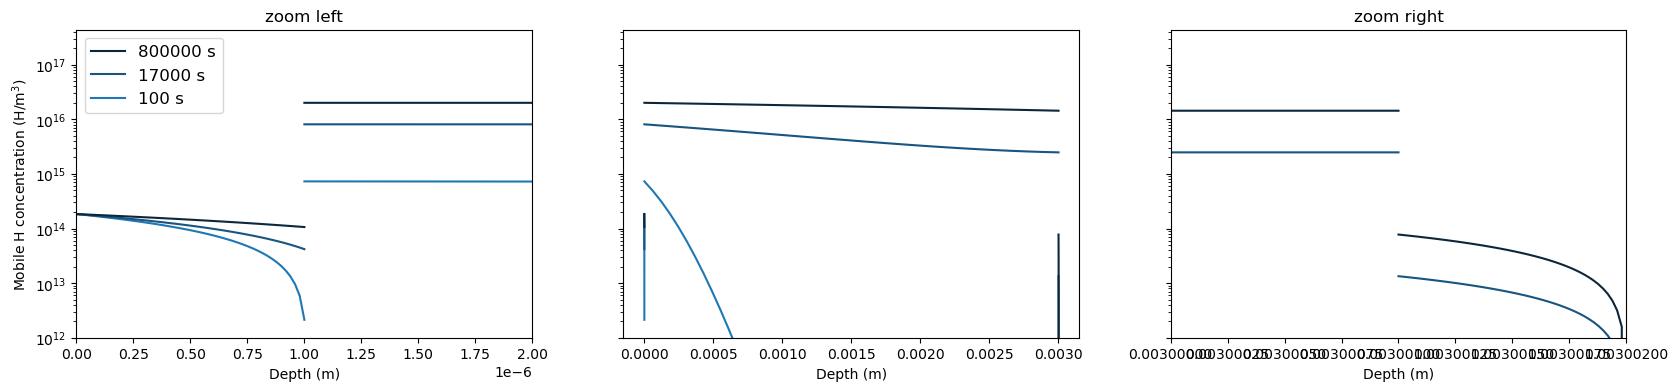

In [11]:
import matplotlib.pyplot as plt

xlim_left = (0, barrier_thick * 2)
xlim_mid = (None, None)
xlim_right = (substrate_thick, substrate_thick + 2 * barrier_thick)

fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(20, 4))

# three shades of blue for the three times
colours = ["#1f77b4", "#185580", "#0C273B"]

for ax, xlim in zip(axs, [xlim_left, xlim_mid, xlim_right]):
    plt.sca(ax)
    for profile in profile_exports:
        for i, time in enumerate(profile.times):
            label = f"{time:.0f} s" if ax == axs[0] and profile == profile_exports[0] else None
            c = profile.data[i]
            ax.plot(profile.x, c, color=colours[i], label=label)

    ax.set_xlim(xlim)
    ax.set_xlabel("Depth (m)")

axs[0].legend(fontsize=12, reverse=True)
axs[0].set_yscale("log")
axs[0].set_ylim(bottom=1e12)
axs[0].set_ylabel("Mobile H concentration (H/m$^3$)")
axs[0].set_title("zoom left")
axs[2].set_title("zoom right")
plt.show()

## 2) Model without barrier

We can also run the equivalent model without permeation barriers with bare tungsten.
Let's make a few modifications:

In [12]:
model_no_barrier = F.HydrogenTransportProblem()

boundary_left = F.SurfaceSubdomain1D(id=1, x=barrier_thick)
boundary_right = F.SurfaceSubdomain1D(id=2, x=substrate_thick + 1 * barrier_thick)
model_no_barrier.subdomains = [volume_tungsten, boundary_left, boundary_right]

# new mesh
model_no_barrier.mesh = F.Mesh1D(np.linspace(*volume_tungsten.borders, num=50))

# change the solubility of the Sievert's condition
left_bc.S_0 = tungsten.K_S_0
left_bc.E_S = tungsten.E_K_S

model_no_barrier.temperature = model_barrier.temperature
model_no_barrier.boundary_conditions = model_barrier.boundary_conditions
model_no_barrier.species = model_barrier.species

model_no_barrier.settings = model_barrier.settings


permeation_flux_no_barrier = F.SurfaceFlux(field=H, surface=boundary_right)
model_no_barrier.exports = [permeation_flux_no_barrier]

model_no_barrier.initialise()
model_no_barrier.run()

Solving HydrogenTransportProblem:   0%|          | 0.00/800k [00:00<?, ?it/s]

## 3) Calculate the PRF

We can plot the temporal evolution of permeation flux with or without permeation barriers:

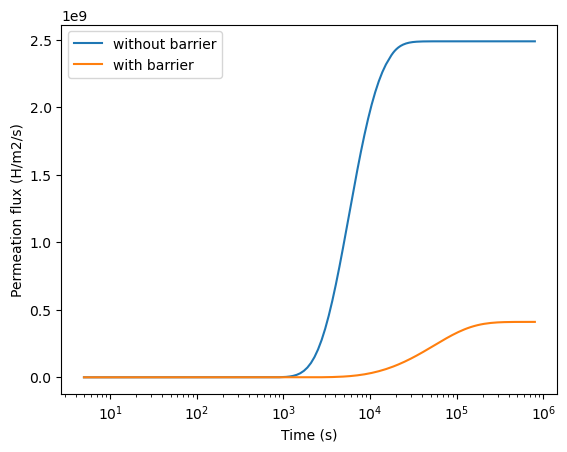

In [13]:
import matplotlib.pyplot as plt
plt.figure()

plt.plot(permeation_flux_no_barrier.t, permeation_flux_no_barrier.data, label="without barrier")
plt.plot(permeation_flux.t, permeation_flux.data, label="with barrier")

plt.xscale("log")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Permeation flux (H/m2/s)")
plt.show()

Clearly, having the coating on both sides reduces the permeation flux!

Moreover, it can be shown that the PRF of this configuration is:

$$\mathrm{PRF} = 1 + 2 \alpha \beta \gamma$$

With 

$$\alpha = D_\mathrm{substrate} / D_\mathrm{barrier} $$

$$\beta = S_\mathrm{substrate} / S_\mathrm{barrier} $$

$$\gamma = e_\mathrm{barrier} / e_\mathrm{substrate} $$

We can compare the computed PRF to the theory.

In [14]:
computed_PRF = permeation_flux_no_barrier.data[-1] / permeation_flux.data[-1]

diff_ratio = tungsten.D_0 / barrier.D_0
sol_ratio = tungsten.K_S_0 / barrier.K_S_0
length_ratio = barrier_thick / substrate_thick

theoretical_PRF = 1 + 2 * diff_ratio * sol_ratio * length_ratio

print(f"Theoretical PRF = {theoretical_PRF:.4f}")
print(f"Computed PRF = {computed_PRF:.4f}")
print(f"Error = {(computed_PRF - theoretical_PRF)/theoretical_PRF:.2%}")

Theoretical PRF = 6.1113
Computed PRF = 6.0617
Error = -0.81%


# Question
Will adding traps to the simulation change the value of the PRF?

<details>
<summary>Show solution</summary>
<br>
No. The PRF is a measure of the flux of mobile particles and is computed at steady state.

At steady state, the McNabb & Foster model states that the concentration of mobile particle is independent of the trapped concentration.

Therefore, the steady state PRF is independent of trapping.

</details>